# PWV effects on SN Magnitude

This notebook demonstrates the effects of PWV absorption on the apparent magnitude of SNe.


In [1]:
import sys
sys.path.insert(0, '../')

import numpy as np
import sncosmo
from astropy.cosmology import WMAP9 as cosmo
from matplotlib import pyplot as plt
from sn_analysis import modeling, sn_magnitudes, reference, plotting
from utils import register_decam_filters

register_decam_filters(force=True)


In [2]:
source = 'salt2-extended'
pwv_vals = np.arange(0, 10)
z_vals = np.arange(.01, 1.1, .05)
bands = 'decam_r', 'decam_i', 'decam_z', 'decam_y'


## Spectral Template

The effect of PWV absorption is fundementally dependent on the interplay between the SED of the effected object and the PWV transmission function. For this work we consider an extend version of the Salt2 spectral template. We visualize the template as a reference.


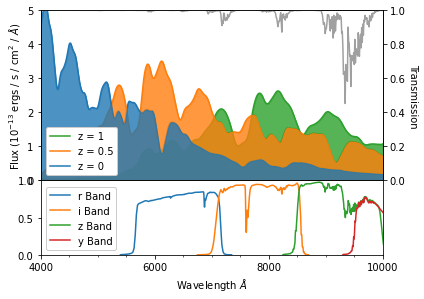

In [3]:
_ = plotting.plot_salt2_extended_template(np.arange(4000, 10000), [0, .5, 1], pwv=4)


## Apparent magnitude

We start by considering the direct impact of PWV absorbtion on simulated SN Ia magnitudes. Apparent magnitudes are simulated for multiple bands, redshifts, and PWV concentrations. 


In [4]:
tabulated_mag = sn_magnitudes.tabulate_mag(source, pwv_vals, z_vals, bands)


Tabulating Mag: 100%|██████████| 880/880 [01:49<00:00,  8.01it/s]


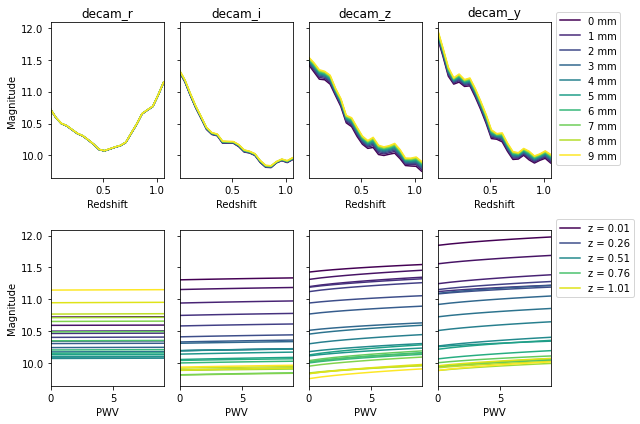

In [5]:
_ = plotting.plot_magnitude(tabulated_mag, pwv_vals, z_vals)

---

**Sanity Check:** As the spectral template is redshifted, the brighter portion of the spectra begins to enter the redder bands. We expect this to cause a temporary decrease in the apparent magnitude until the redshift becomes large enough that growing distance results in a monotonically increasing magnitude (This effect becomes more obvious when looking at the spectra template above).

---

To better understand the impact of PWV, we estimate the change in apparent magnitude due to PWV. Although we could measure this change relative to PWV=0, a more physically motivated approach is to use a fiducial atmosphere with a non-zero PWV component:

$$\Delta m = m(\text{PWV}, z) - m(\text{PWV}_f, z)$$

We also determine the slope in the apparent magnitude as an estimate for how sensitive our simulated observations are to PWV fluxtuations:

$$\frac{\Delta m}{\Delta \text{PWV}}(z) = \frac{m(\text{PWV}_2, z) - m(\text{PWV}_1, z)}{\text{PWV}_2 - \text{PWV}_1}$$

Here PWV$_1$ and PWV$_2$ are chosen to be equidistant to PWV$_f$. We take note of the chosen PWV reference values in the following cell:


In [6]:
reference_pwv_config = reference.get_config_pwv_vals()
print(reference_pwv_config)


{'reference_pwv': 4.0, 'slope_start': 2.0, 'slope_end': 6.0}


We tabulate values for $\Delta m$ and $\frac{\Delta m}{\Delta \text{PWV}}(z)$. 

In [7]:
fiducial_mag = sn_magnitudes.tabulate_fiducial_mag(
        source, z_vals, bands, reference_pwv_config)

tabulated_delta_mag, tabulated_slope = sn_magnitudes.calc_delta_mag(
    tabulated_mag, fiducial_mag, reference_pwv_config)


Tabulating Mag: 100%|██████████| 264/264 [00:33<00:00,  7.87it/s]


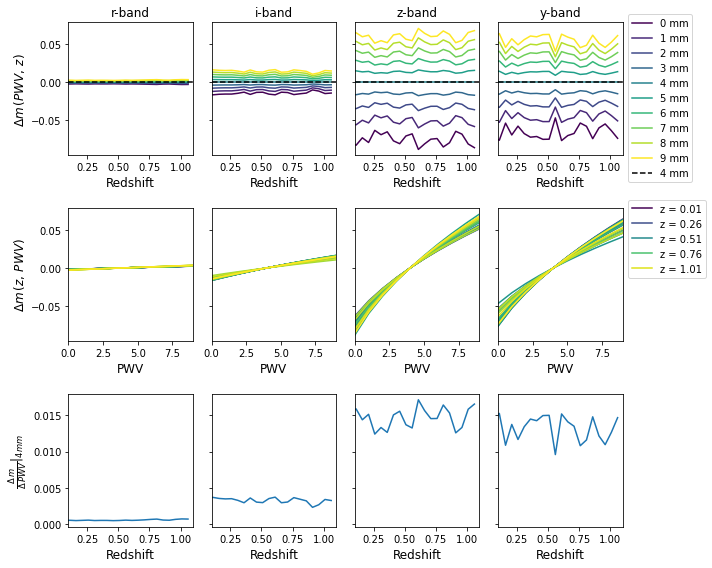

In [8]:
_ = plotting.plot_pwv_mag_effects(
    pwv_vals, 
    z_vals, 
    tabulated_delta_mag, 
    tabulated_slope, 
    bands)


---

**Sanity Check:** We expect to see the following trends in the above plot:
- The bluer bands should have minimal PWV impact. 
- The size of $\Delta$m should be largest for the redder bands. 
- The slope in $\Delta$m should be largest in the redder bands, and almost zero in the blewer bands.
- $\Delta$m should be zero for the fiducial PWV value.

---

## $\Delta m$ With Fitting

Instead of tabulating the simulating magnitude, we can instead consider the change in magnitude by simulating light-curves with PWV effects and then fitting a model without a PWV component.

In [9]:
# Realize simulations of light-curves
observations = modeling.create_observations_table()
light_curves = modeling.iter_lcs(observations, source, pwv_vals, z_vals)

# Fit light curves
vparams = ['x0', 'x1', 'c']
fitted_mag, fitted_params = sn_magnitudes.fit_mag(
        source, light_curves, vparams, pwv_vals, z_vals, bands)

# Get fiducial mag (uncalibrated)
fitted_fiducial_mag, fitted_fiducial_params = sn_magnitudes.fit_fiducial_mag(
        source, observations, vparams, z_vals, bands, reference_pwv_config)


Light-Curves: 100%|██████████| 66/66 [01:08<00:00,  1.04s/it]


Here we visualize the fitted, uncalibrated (i.e. without any stretch / color corrections) magnitudes.

Text(0.5, 1.05, 'Fitted Magnitude')

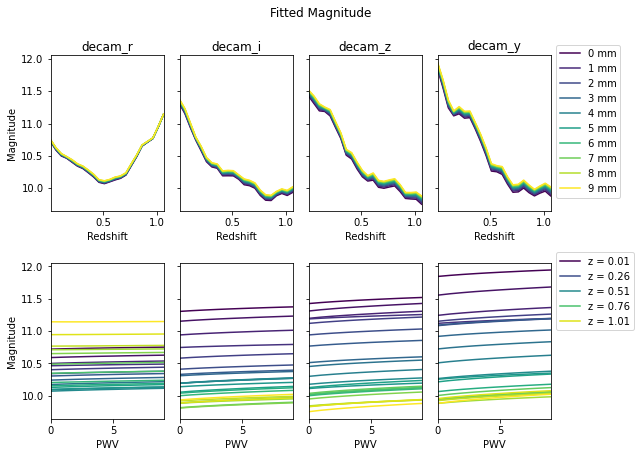

In [10]:
fig, axes = plotting.plot_magnitude(fitted_mag, pwv_vals, z_vals)
fig.suptitle('Fitted Magnitude', y=1.05)


---

**Sanity Check:** The fitted light-curves are constructed by design to have a dense, uniform sampling. The fitted magnitude should thus look extremly similar to the tabulated magnitudes from earlier in the notebook.

---

We expect to see almost no difference between the tabulated, and fitted magnitudes in each band. However, we do expect to variation in the fitted stretch and color.

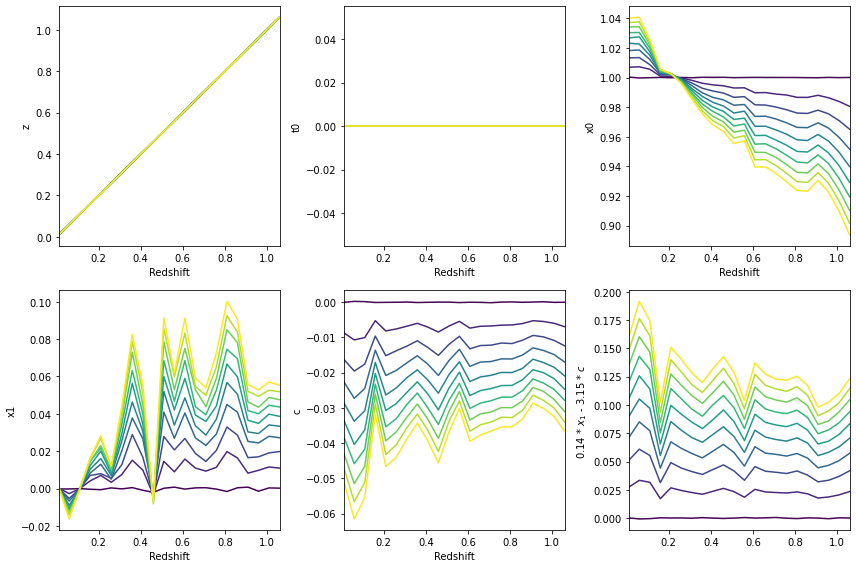

In [11]:
# Parse the fitted parameters for easier plotting
model = sncosmo.Model('salt2-extended')
params_dict = {
    param: fitted_params[bands[0]][..., i] for 
    i, param in enumerate(model.param_names)
}

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for axis, (param, param_vals) in zip(axes.flatten(), params_dict.items()):
    plotting.multi_line_plot(z_vals, param_vals, pwv_vals, axis)
    axis.set_xlabel('Redshift')
    axis.set_ylabel(param)
    
correction_factor = sn_magnitudes.α * params_dict['x1'] - sn_magnitudes.β * params_dict['c']
plotting.multi_line_plot(z_vals, correction_factor, pwv_vals, axes[-1][-1])

label = f'{sn_magnitudes.α} * $x_1$ - {sn_magnitudes.β} * $c$'
axes[-1][-1].set_ylabel(label)
    
plt.tight_layout()


Like before we look at the impact of PWV on the fitted magnitude, but we also look at the cirrected magnitude.

In [12]:
corrected_delta_mag, corrected_slope = sn_magnitudes.calc_delta_mag(
    fitted_mag, fitted_fiducial_mag, reference_pwv_config)


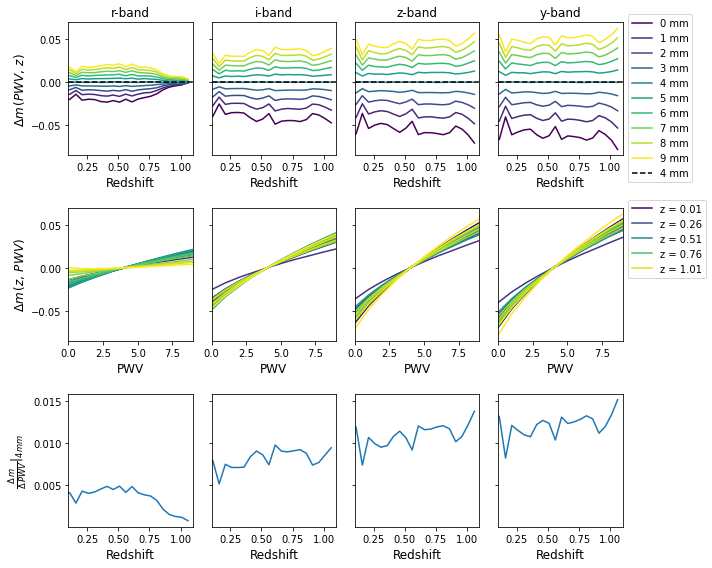

In [13]:
fig, axes = plotting.plot_pwv_mag_effects(
    pwv_vals, 
    z_vals, 
    corrected_delta_mag, 
    corrected_slope, 
    bands)


Next we add in the alpha and beta parameters from the fit.

In [14]:
# Determine calibrated magnitude from fits
calibrated_mag = {}
calibrated_fiducial_mag = {}
for band in bands:
    calibrated_mag[band] = sn_magnitudes.calibrate_mag(
        source, fitted_mag[band], fitted_params[band])

    # Get fiducial mag (calibrated)
    calibrated_fiducial_mag[band] = sn_magnitudes.calibrate_mag(
        source, fitted_fiducial_mag[band], fitted_fiducial_params[band])

calibrated_delta_mag, calibrated_slope = sn_magnitudes.calc_delta_mag(
        calibrated_mag, calibrated_fiducial_mag, reference_pwv_config)


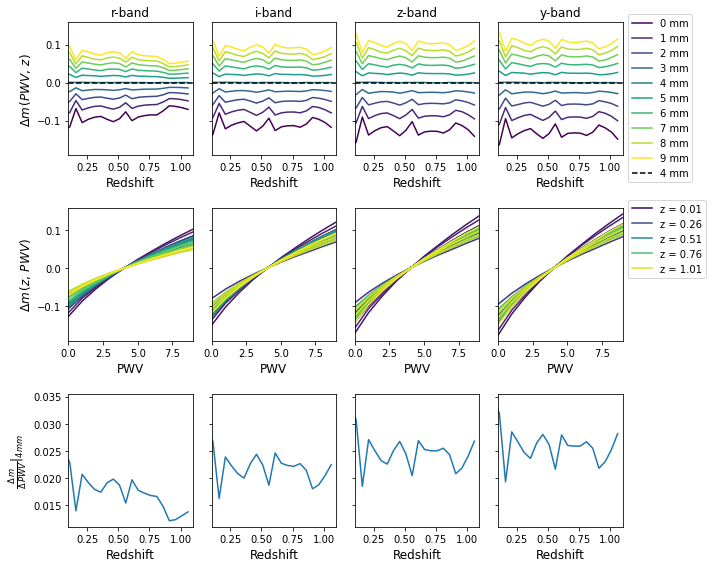

In [15]:
_ = plotting.plot_pwv_mag_effects(
    pwv_vals, 
    z_vals, 
    calibrated_delta_mag, 
    calibrated_slope, 
    bands)


# Relative to reference Star

In practice flux values are calibrated relative to a reference star. To understand how PWV effects SNe fluxes under these conditions, we normalize the SNe and Reference star flux to their respective fluxes through the fiducial atmosphere and take the difference (Normalized SNe - normalized reference star).

Note that the value of $\Delta m$ is we calculated before is equivilent to the apparent SN magnitude normalized to the flux through the fiducial atmosphere.

$$\Delta m = m(\text{PWV}, z) - m(\text{PWV}_f, z) = -2.5 log\left(\frac{f(\text{PWV}, z)}{f(\text{PWV}_f, z)}\right)$$

In [16]:
def calibrate_to_reference(delta_mag, slope, pwv_vals, reference_type='G2'):
    
    assert delta_mag.keys() == slope.keys()
    
    delta_mag_ref = {}
    slope_ref = {}
    for band in delta_mag:
        
        delta_mag_ref[band] = reference.subtract_ref_star(
            band, delta_mag[band], pwv_vals, reference_type)
        
        slope_ref[band] = reference.subtract_ref_star_slope(
            band, slope[band], reference_pwv_config, reference_type)
        
    return delta_mag_ref, slope_ref
        

In [17]:
# The y band values are not available for the reference star
# we drop them here

_tabulated_delta_mag = tabulated_delta_mag.copy()
_tabulated_delta_mag.pop('decam_y')

_tabulated_slope = tabulated_slope.copy()
_tabulated_slope.pop('decam_y')

tabulated_delta_mag_g2 = reference.subtract_ref_star(_tabulated_delta_mag, pwv_vals)
tabulated_slope_g2 = reference.subtract_ref_star_slope(_tabulated_slope, reference_pwv_config)


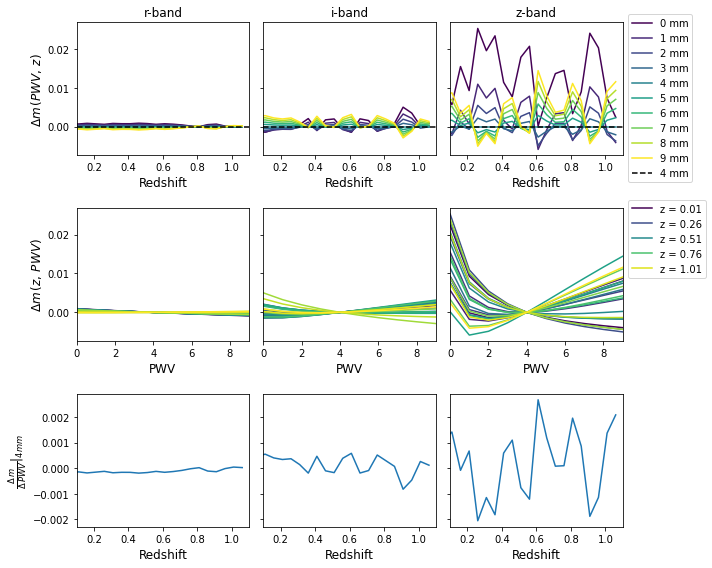

In [18]:
_ = plotting.plot_pwv_mag_effects(
    pwv_vals, 
    z_vals, 
    tabulated_delta_mag_g2, 
    tabulated_slope_g2, 
    bands[:-1])


In [19]:
# The y band values are not available for the reference star
# we drop them here

_corrected_delta_mag = corrected_delta_mag.copy()
_corrected_delta_mag.pop('decam_y')

_corrected_slope = corrected_slope.copy()
_corrected_slope.pop('decam_y')

corrected_delta_mag_g2 = reference.subtract_ref_star(_corrected_delta_mag, pwv_vals)
corrected_slope_g2 = reference.subtract_ref_star_slope(_corrected_slope, reference_pwv_config)


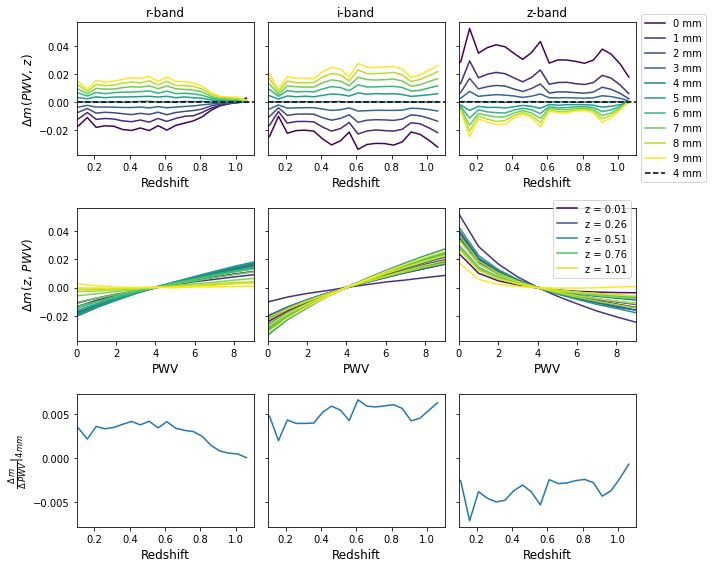

In [20]:
_ = plotting.plot_pwv_mag_effects(
    pwv_vals, 
    z_vals, 
    corrected_delta_mag_g2,
    corrected_slope_g2,
    bands)


We also try using an M9 star instead of a G2, and see little difference.

In [21]:
corrected_delta_mag_m9 = reference.subtract_ref_star(_corrected_delta_mag, pwv_vals, 'M9')
corrected_slope_m9 = reference.subtract_ref_star_slope(_corrected_slope, reference_pwv_config, 'M9')


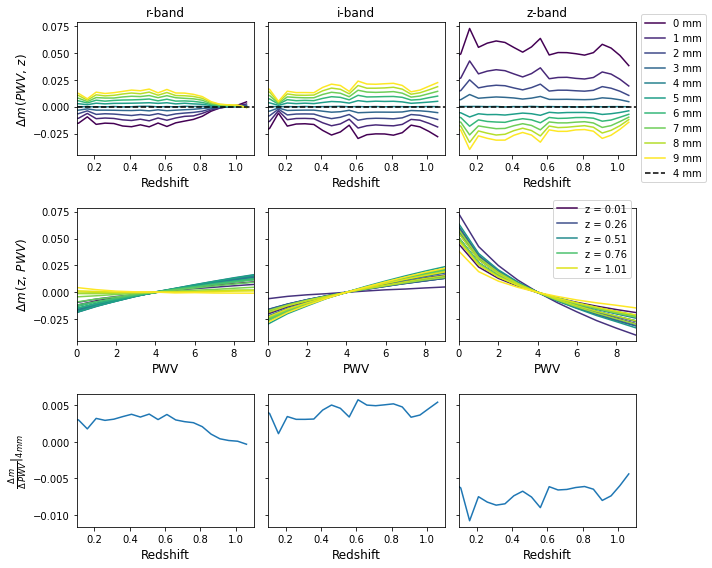

In [22]:
_ = plotting.plot_pwv_mag_effects(
    pwv_vals, 
    z_vals, 
    corrected_delta_mag_m9,
    corrected_slope_m9,
    bands)


## Delta $\mu$

To understand the impact on PWV on $\mu$, we look at the rest frame B-band.

In [23]:
fitted_mu = sn_magnitudes.calc_mu_for_params(source, fitted_params['decam_r']) # Params should be band independent
cosmo_mu = cosmo.distmod(z_vals).value
delta_mu = fitted_mu - cosmo_mu


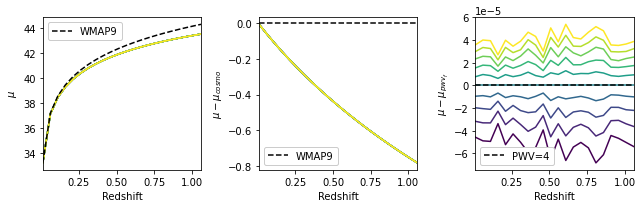

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
mu_ax, delta_mu_ax, relative_mu_ax = axes

plotting.multi_line_plot(z_vals, fitted_mu, pwv_vals, mu_ax)
mu_ax.plot(z_vals, cosmo_mu, linestyle='--', color='k', label='WMAP9')
mu_ax.legend(framealpha=1)

plotting.multi_line_plot(z_vals, delta_mu, pwv_vals, delta_mu_ax)
delta_mu_ax.axhline(0, linestyle='--', color='k', label='WMAP9')
delta_mu_ax.legend(framealpha=1)

plotting.multi_line_plot(z_vals, fitted_mu - fitted_mu[4], pwv_vals, relative_mu_ax)
relative_mu_ax.axhline(0, linestyle='--', color='k', label=f'PWV={pwv_vals[4]}')
relative_mu_ax.legend(framealpha=1)

mu_ax.set_ylabel(r'$\mu$')
delta_mu_ax.set_ylabel(r'$\mu - \mu_{cosmo}$')
relative_mu_ax.set_ylabel(r'$\mu - \mu_{pwv_f}$')
for ax in axes:
    ax.set_xlabel('Redshift')

plt.tight_layout()
